In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import joblib
import pickle

In [2]:
df=pd.read_csv('../input/sentimententerpret/train.csv')
test=pd.read_csv("../input/sentimententerpret/test.csv")
testtxt=test['text']
df.head()

,text,aspect,label
0,can you check whether its cancelled completely?,cancelled,1
1,cannot rely on both milk delivery and grocery ...,Milk,0
2,"I get no notification, however the app is real...",notification,0
3,"Love this app, but would love it even more if ...",view,1
4,it does not let me load a clip on the scene,load,0


In [3]:
df.shape

(4000, 3)

In [4]:
df.dropna()

,text,aspect,label
0,can you check whether its cancelled completely?,cancelled,1
1,cannot rely on both milk delivery and grocery ...,Milk,0
2,"I get no notification, however the app is real...",notification,0
3,"Love this app, but would love it even more if ...",view,1
4,it does not let me load a clip on the scene,load,0
...,...,...,...
3995,every time i try to edit a page or create a li...,tools,0
3996,unable to load money using wallets (phonepe/ol...,Unable to load money using wallets,0
3997,"hi, i m doing for the first time ever and i no...",usage,0
3998,delivery is delayed or cancelled every time i ...,Delivery,0


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

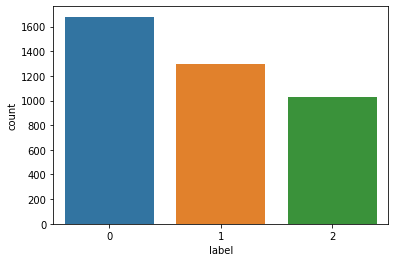

In [5]:
sns.countplot(df.label)

In [6]:
# removing the html tags
def clean_html(text):
    clean=re.compile('<.*?>')
    cleantext=re.sub(clean,'',text)
    return cleantext
    
# first round of cleaning
def clean_text1(text):
    text=text.lower()
    text=re.sub('\[.*?\]','',text)
    text=re.sub('[%s]'%re.escape(string.punctuation),'',text)
    text=re.sub('\w*\d\w*','',text)
    return text

# second round of cleaning
def clean_text2(text):
    text=re.sub('[''"",,,]','',text)
    text=re.sub('\n','',text)
    return text
    
cleaned_html=lambda x:clean_html(x)
cleaned1=lambda x:clean_text1(x)
cleaned2=lambda x:clean_text2(x)

df['text']=pd.DataFrame(df.text.apply(cleaned_html))
df['text']=pd.DataFrame(df.text.apply(cleaned1))
df['text']=pd.DataFrame(df.text.apply(cleaned2))

test['text']=pd.DataFrame(test.text.apply(cleaned_html))
test['text']=pd.DataFrame(test.text.apply(cleaned1))
test['text']=pd.DataFrame(test.text.apply(cleaned2))

df=df.drop(columns='aspect')
aspect=test['aspect']
test=test.drop(columns='aspect')
df.head()

,text,label
0,can you check whether its cancelled completely,1
1,cannot rely on both milk delivery and grocery ...,0
2,i get no notification however the app is reall...,0
3,love this app but would love it even more if g...,1
4,it does not let me load a clip on the scene,0


In [7]:
def remove_stopword(text):
    stopword=nltk.corpus.stopwords.words('english')
    stopword.remove('not')
    a=[w for w in nltk.word_tokenize(text) if w not in stopword]
    return ' '.join(a)
df['text'] = df['text'].apply(remove_stopword)
test['text'] = test['text'].apply(remove_stopword)

In [8]:
df

,text,label
0,check whether cancelled completely,1
1,not rely milk delivery grocery items,0
2,get notification however app really fine,0
3,love app would love even gantt charts calendar...,1
4,not let load clip scene,0
...,...,...
3995,every time try edit page create link tools key...,0
3996,unable load money using wallets phonepeola mon...,0
3997,hi first time ever not able understand usage t...,0
3998,delivery delayed cancelled every time order so...,0


In [9]:
vectr = TfidfVectorizer(ngram_range=(1,2),min_df=1)
vectr.fit(df['text'])
vect_X = vectr.transform(df['text'])

In [10]:
model = LogisticRegression()
clf=model.fit(vect_X,df['label'])
clf.score(vect_X,df['label'])*100

92.35

In [11]:
clf.predict(vectr.transform(['i am using machine learning for a project on sentiment analysis']))

array([1])

In [12]:
filename = 'finalized_model.sav'
joblib.dump(model, filename)

['finalized_model.sav']

In [13]:
pickle.dump(model, open("model.pkl", "wb"))

In [14]:
predict = model.predict(vectr.transform(test['text']))
output = pd.DataFrame({'text':testtxt,'aspect':aspect,'label': predict})
output.to_csv('my_submission.csv', index=False)
print("Submission saved")

Submission saved


In [15]:
clf.score(vectr.transform(test['text']),output['label'])*100

100.0

In [16]:
output

,text,aspect,label
0,improve your customer service and product avai...,Customer service,0
1,functionality is great almost as in desktop ve...,mobile version,0
2,but it keeps starting from zoomed in and then ...,zoomed,0
3,hey marilyn thanks for your answer the type ...,Security,1
4,delanovc zoom airtable notionhq calendly apple...,apple,1
...,...,...,...
995,in a database where i have multiple views enab...,views,0
996,the mere act of opening the notionhq tab makes...,opening,0
997,i have shared it to web now and added the link...,web,1
998,why the members who regularly buy milk has to ...,service charge.,0
